# WGAN Model and Training on CIFAR

In [23]:
# Load the Datasets
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


## Hyperparameters

In [24]:
# Constants
image_resize_dimension = 64
default_batch_size = 64
batch_size = 64
real_label = 1
fake_label = 0

# Hyper parameters
image_channels = 3
z_dim = 256
learning_rate = 0.0001

hidden_dim_size = 32 # How complex the generator and discriminator models are
num_epochs = 25
clip_value = 0.01  # Adjust as needed

In [25]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transcform_cifar_norm = transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5)).to(default_device)
transform_cifar = transforms.Compose([transforms.ToTensor(), 
                                      transcform_cifar_norm,
                                      transforms.Resize(image_resize_dimension)])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=default_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
# Print some of the CIFAR dataset samples if flag is set
print_sample = False
if print_sample:
    real_batch = next(iter(trainloader_cifar))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [27]:
# Proper way to initialize weights for the generator and discriminator networks based on reasearch paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [28]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden_layer_size=64, img_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(z_dim, hidden_layer_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 8, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 4, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 2, hidden_layer_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(hidden_layer_size, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        ).to(default_device)

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, hidden_layer_size=64, img_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(img_channels, hidden_layer_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(hidden_layer_size, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(hidden_layer_size * 2, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(hidden_layer_size * 4, hidden_layer_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output layer is not a probability. So no sigmoid, just another layer
            nn.Conv2d(hidden_layer_size * 8, 1, 4, 1, 0, bias=False),
        ).to(default_device)

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [29]:
# Initialize BCELoss function
criterion = nn.BCELoss()

generator = Generator(z_dim, hidden_dim_size, image_channels)
generator.apply(weights_init)
# print(generator_cifar)
discriminator = Discriminator(hidden_dim_size, image_channels)
discriminator.apply(weights_init)
# print(discriminator_cifar)

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

In [30]:
# Arrays to store losses and EMD values during training
d_losses = []
g_losses = []
emd_values = []

In [31]:
# Training loop using Weight Clipping
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(trainloader_cifar):
        # Train Discriminator
        discriminator.zero_grad()

        # Grab the real images
        real_images = Variable(real_images).to(default_device)
        batch_size = real_images.size(0)

        # Generate fake images
        z = Variable(torch.randn(batch_size, z_dim, 1, 1)).to(default_device)
        fake_images = generator(z)

        # Discriminator output for real and fake images - use them both for backpropogation
        real_outputs = discriminator(real_images)
        real_loss = -torch.mean(real_outputs)
        real_loss.backward(retain_graph=True)

        # Backpropogation for fake images
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = torch.mean(fake_outputs)
        fake_loss.backward(retain_graph=True)

        # Compute Wasserstein distance
        discriminator_loss = real_loss + fake_loss

        # Weight clipping for the descriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        optimizer_D.step()

        # Train Generator every 4th iteration
        if i % 4 == 0:
            generator.zero_grad()
            fake_outputs_gen = discriminator(fake_images)
            generator_loss = -torch.mean(fake_outputs_gen)
            generator_loss.backward()
            optimizer_G.step()

        # Record losses
        d_losses.append(discriminator_loss.item())
        g_losses.append(generator_loss.item())

        # Earth Mover’s Distance (EMD) calculation
        emd_value = -(real_loss + fake_loss).item()
        emd_values.append(emd_value)

        # Print progress
        if i % 1000 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D loss: %.4f] [G loss: %.4f] [EMD: %.4f]' %
                  (epoch, num_epochs, i, len(trainloader_cifar), discriminator_loss.item(), generator_loss.item(), emd_value))

[Epoch 0/25] [Batch 0/782] [D loss: -0.5667] [G loss: 0.0082] [EMD: 0.5667]
[Epoch 1/25] [Batch 0/782] [D loss: -0.3127] [G loss: 0.1843] [EMD: 0.3127]
[Epoch 2/25] [Batch 0/782] [D loss: -0.3581] [G loss: 0.2305] [EMD: 0.3581]
[Epoch 3/25] [Batch 0/782] [D loss: -0.2208] [G loss: 0.0274] [EMD: 0.2208]
[Epoch 4/25] [Batch 0/782] [D loss: -0.2836] [G loss: 0.2121] [EMD: 0.2836]
[Epoch 5/25] [Batch 0/782] [D loss: -0.2317] [G loss: 0.2084] [EMD: 0.2317]
[Epoch 6/25] [Batch 0/782] [D loss: -0.2941] [G loss: 0.1963] [EMD: 0.2941]
[Epoch 7/25] [Batch 0/782] [D loss: -0.2595] [G loss: 0.1331] [EMD: 0.2595]
[Epoch 8/25] [Batch 0/782] [D loss: -0.2184] [G loss: 0.2023] [EMD: 0.2184]
[Epoch 9/25] [Batch 0/782] [D loss: -0.2040] [G loss: 0.1185] [EMD: 0.2040]
[Epoch 10/25] [Batch 0/782] [D loss: -0.2471] [G loss: 0.0930] [EMD: 0.2471]
[Epoch 11/25] [Batch 0/782] [D loss: -0.1915] [G loss: 0.1803] [EMD: 0.1915]
[Epoch 12/25] [Batch 0/782] [D loss: -0.2451] [G loss: 0.0851] [EMD: 0.2451]
[Epoch 13

## Plot the Results

Text(0.5, 1.0, 'Earth Mover’s Distance (EMD)')

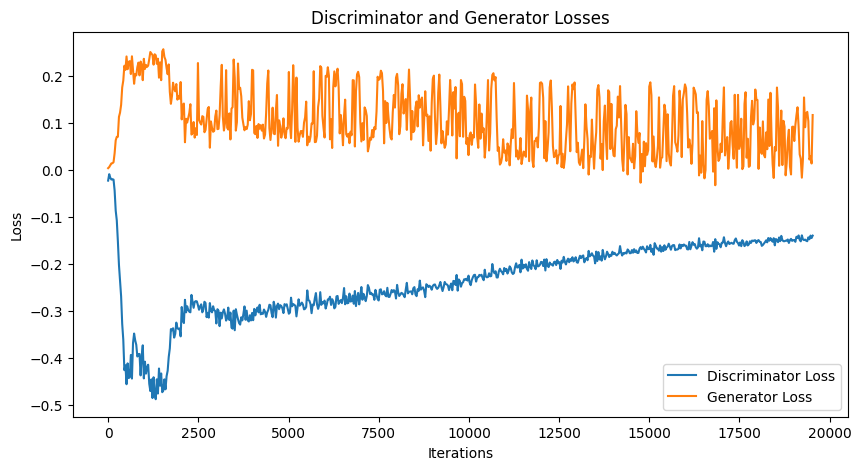

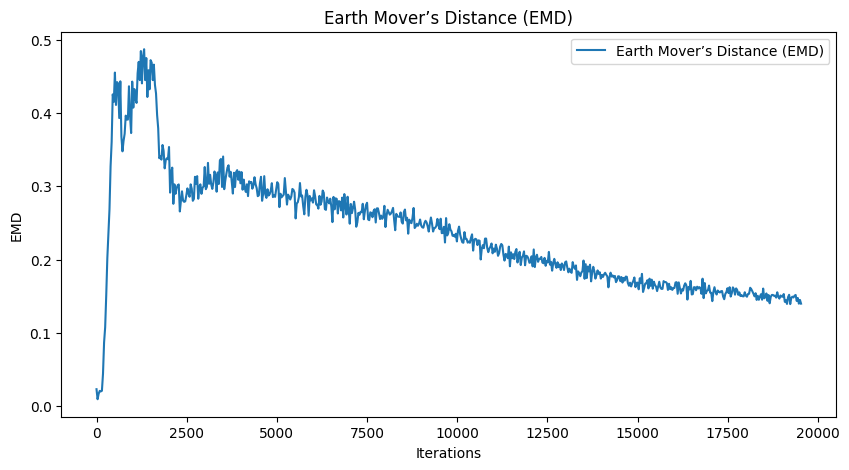

In [32]:
# Plot losses and EMD values
number_bins = 30

# Bin the discriminator losses and calculate the averages
binned_d_losses = [np.mean(d_losses[i:i + number_bins]) for i in range(0, len(d_losses), number_bins)]
binned_g_losses = [np.mean(g_losses[i:i + number_bins]) for i in range(0, len(g_losses), number_bins)]
binned_emd_values = [np.mean(emd_values[i:i + number_bins]) for i in range(0, len(emd_values), number_bins)]

plt.figure(figsize=(10, 5))
plt.plot(range(0, len(d_losses), number_bins), binned_d_losses, label='Discriminator Loss')
plt.plot(range(0, len(g_losses), number_bins), binned_g_losses, label='Generator Loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title('Discriminator and Generator Losses')

plt.figure(figsize=(10, 5))
plt.plot(range(0, len(emd_values), number_bins), binned_emd_values, label='Earth Mover’s Distance (EMD)')
plt.legend()
plt.ylabel("EMD")
plt.xlabel("Iterations")
plt.title('Earth Mover’s Distance (EMD)')

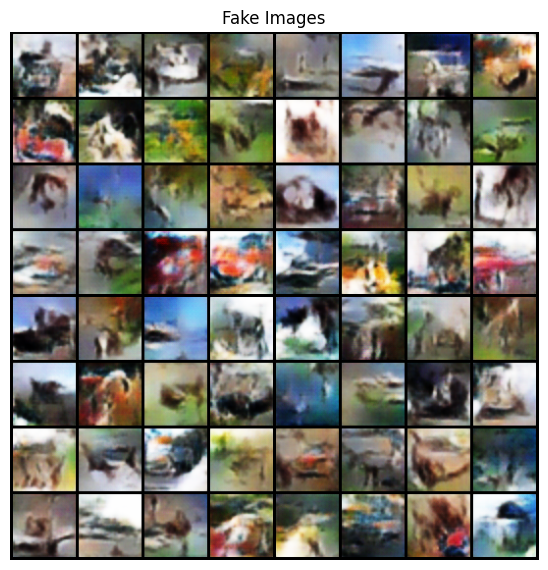

In [33]:
num_images_to_show = 64

# Save generated images from the last training iteration
with torch.no_grad():
    z = Variable(torch.randn(num_images_to_show, z_dim, 1, 1)).to(default_device)
    generated_images = generator(z).cpu().numpy()

# Plot the fake images from the last epoch
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(generated_images[:num_images_to_show]).to(default_device), padding=3, normalize=True).cpu(),(1,2,0)))
plt.show()